**Run the following two cells before you begin.**

In [2]:
%autosave 10

Autosaving every 10 seconds


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve

%matplotlib inline

**First, import the cleaned data set. Then, select the features from the DataFrame of the case study data.**
    
These features should be: `'LIMIT_BAL'`, `'EDUCATION'`, `'MARRIAGE'`, `'AGE'`, `'PAY_1'`, `'BILL_AMT1'`, `'BILL_AMT2'`, `'BILL_AMT3'`, `'BILL_AMT4'`, `'BILL_AMT5'`, `'BILL_AMT6'`, `'PAY_AMT1'`, `'PAY_AMT2'`, `'PAY_AMT3'`, `'PAY_AMT4'`, `'PAY_AMT5'`, AND `'PAY_AMT6'`.

In [4]:
# Import data set
df = pd.read_csv("cleaned_data.csv")

In [5]:
# Create features list
X = df[['LIMIT_BAL','EDUCATION','MARRIAGE','AGE','PAY_1','BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5',
        'BILL_AMT6','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']]
Y = df['default payment next month']

_____________________________________________________
**Next, make a 80:20 train/test split using a random seed of 24.**

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20, random_state = 24)

_____________________________________________________
**Then, instantiate the `MinMaxScaler` to scale the data.**

In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

_____________________________________________________
**Next, instantiate a logistic regression model with the `saga` solver, L1 penalty, and set `max_iter` to 1,000 as we want the solver to have enough iterations to find a good solution.**

In [8]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver = 'saga', max_iter = 1000)

_____________________________________________________
**Next, import the `Pipeline` class and create a `Pipeline` with the scaler and the logistic regression model, using the names `'scaler'` and `'model'` for the steps, respectively.**

In [9]:
from sklearn.pipeline import Pipeline

Input = [('scaler',MinMaxScaler()),('model',LogisticRegression(solver = 'saga', max_iter = 1000))]

pipe = Pipeline(Input)


_____________________________________________________
**Now, use the `get_params` method to view the parameters from each stage of the pipeline.**

In [10]:
# Use `get_params`
pipe.get_params

<bound method Pipeline.get_params of Pipeline(memory=None,
         steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('model',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=1000,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='saga', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)>

**Use the `set_params` method to change the the `model__C` parameter to 2.**

In [11]:
# View what `model__C` is set to currently
pipe[1].get_params('C')

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'saga',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [12]:
# Change `model__C` to 2
k = {'C':2.0}
pipe[1].set_params(**k)

LogisticRegression(C=2.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

_____________________________________________________
**Then, create a smaller range of C values to test with cross-validation, as these models will take longer to train and test with more data than our previous activities.**

**Use C_vals = [$10^2$, $10$, $1$, $10^{-1}$, $10^{-2}$, $10^{-3}$].**


<details>
    <summary>Hint:</summary>
    Recall that exponents in Python use the ** operator.
</details>

In [13]:
C_vals = [10**2,10,1,10**(-1),10**(-2),10**(-3)]

Now, define `k_folds` using `StratifiedKFold`. The number of folds should be 4. Set the random state to 1.

In [14]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
n_folds = 4
k_folds = KFold(n_splits=n_folds, shuffle=False, random_state=1)


C:\Users\Antony Pradeep\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


_____________________________________________________
**Next, make a new version of the `cross_val_C_search` function, called `cross_val_C_search_pipe`. Instead of the model argument, this function will take a pipeline argument. The changes inside the function will be to set the `C` value using `set_params(model__C = <value you want to test>)` on the pipeline, replacing the model with the pipeline for the fit and `predict_proba` methods, and accessing the `C` value using `pipeline.get_params()['model__C']` for the printed status update.**

In [47]:
def cross_val_C_search_pipe(k_folds, C_vals, pipeline, X, Y):
    n_folds = k_folds.n_splits
    cv_train_roc_auc = np.empty((n_folds, len(C_vals)))
    cv_test_roc_auc = np.empty((n_folds, len(C_vals)))
    cv_test_roc = [[]]*len(C_vals)
    for c_val_counter in range(len(C_vals)):
        #Set the C value for the model object
        pipeline.set_params(model__C = C_vals[c_val_counter])
        #Count folds for each value of C
        fold_counter = 0
        #Get training and testing indices for each fold
        print(k_folds.split(X, Y))
        for train_index, test_index in k_folds.split(X, Y):
            #Subset the features and response, for training and testing data for
            #this fold
            X_cv_train, X_cv_test = X.iloc[train_index], X.iloc[test_index]
            y_cv_train, y_cv_test = Y.iloc[train_index], Y.iloc[test_index]
            #Fit the model on the training data
            pipeline.fit(X_cv_train, y_cv_train)
            #Get the training ROC AUC
            y_cv_train_predict_proba = pipeline.predict_proba(X_cv_train)
            cv_train_roc_auc[fold_counter, c_val_counter] = \
            roc_auc_score(y_cv_train, y_cv_train_predict_proba[:,1])
            #Get the testing ROC AUC
            y_cv_test_predict_proba = pipeline.predict_proba(X_cv_test)
            cv_test_roc_auc[fold_counter, c_val_counter] = \
            roc_auc_score(y_cv_test, y_cv_test_predict_proba[:,1])
            #Testing ROC curves for each fold
            this_fold_roc = roc_curve(y_cv_test, y_cv_test_predict_proba[:,1])
            cv_test_roc[c_val_counter].append(this_fold_roc)
            #Increment the fold counter
            fold_counter += 1
            #Indicate progress
        print('Done with C = {}'.format(pipeline.get_params()['model__C']))
    return cv_train_roc_auc, cv_test_roc_auc, cv_test_roc
    

_____________________________________________________
**Now, run this function as in the previous activity, but using the new range of `C` values, the pipeline you created, and the features and response variable from the training split of the case study data.**

    You may see warnings here, or in later steps, about the non-convergence of the solver; you could experiment with the `tol` or `max_iter`` options to try and achieve convergence, although the results you obtain with `max_iter = 1000` are likely to be sufficient.

In [32]:
cv_train_roc_auc, cv_test_roc_auc, cv_test_roc = cross_val_C_search_pipe(k_folds, C_vals, pipe, X, Y)

<generator object _BaseKFold.split at 0x0000027D356A49C8>
Done with C = 100
<generator object _BaseKFold.split at 0x0000027D356A49C8>
Done with C = 10
<generator object _BaseKFold.split at 0x0000027D356A49C8>
Done with C = 1
<generator object _BaseKFold.split at 0x0000027D356A41C8>
Done with C = 0.1
<generator object _BaseKFold.split at 0x0000027D356A49C8>
Done with C = 0.01
<generator object _BaseKFold.split at 0x0000027D356A49C8>
Done with C = 0.001


_____________________________________________________
**Plot the average training and testing ROC AUC across folds, for each `np.log(C_vals)` value.**

Text(0.5, 1.0, 'Cross validation scores for each fold')

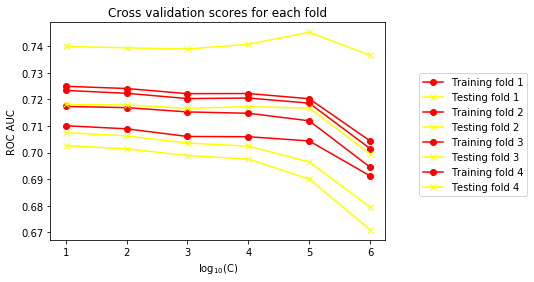

In [35]:
for this_fold in range(n_folds):
    plt.plot([1,2,3,4,5,6], cv_train_roc_auc[this_fold], '-o',
             color='red', label='Training fold {}'.format(this_fold+1))
    plt.plot([1,2,3,4,5,6], cv_test_roc_auc[this_fold], '-x',
             color='yellow', label='Testing fold {}'.format(this_fold+1))
plt.ylabel('ROC AUC')
plt.xlabel('log$_{10}$(C)')
plt.legend(loc = [1.1, 0.2])
plt.title('Cross validation scores for each fold')

_____________________________________________________
**Up next, create interaction features for the case study data using scikit-learn's `PolynomialFeatures`. You should use 2 as the degree of polynomial features. Confirm that the number of new features makes sense.**

In [37]:
from sklearn.preprocessing import PolynomialFeatures
poly_reg = PolynomialFeatures(degree = 2)
X_poly = poly_reg.fit_transform(X)
poly_reg.fit(X_poly, Y)

PolynomialFeatures(degree=2, include_bias=True, interaction_only=False,
                   order='C')

_____________________________________________________
**Finally, repeat the cross-validation procedure and observe the model performance now.**

In [38]:
# Using the new features, make a 80:20 train/test split using a random seed of 24.**
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_poly, Y, test_size = 0.20, random_state = 24)

In [46]:
# Call the cross_val_C_search_pipe() function using the new training data.
# All other parameters should remain the same.
# Note that this training may take a few minutes due to the larger number of features.

def cross_val_C_search_pipe_1(k_folds, C_vals, pipeline, X, Y):
    n_folds = k_folds.n_splits
    cv_train_roc_auc = np.empty((n_folds, len(C_vals)))
    cv_test_roc_auc = np.empty((n_folds, len(C_vals)))
    cv_test_roc = [[]]*len(C_vals)
    for c_val_counter in range(len(C_vals)):
        #Set the C value for the model object
        pipeline.set_params(model__C = C_vals[c_val_counter])
        #Count folds for each value of C
        fold_counter = 0
        #Get training and testing indices for each fold
        print(k_folds.split(X, Y))
        for train_index, test_index in k_folds.split(X, Y):
            #Subset the features and response, for training and testing data for
            #this fold
            X_cv_train, X_cv_test = X[train_index], X[test_index]
            y_cv_train, y_cv_test = Y.iloc[train_index], Y.iloc[test_index]
            #Fit the model on the training data
            pipeline.fit(X_cv_train, y_cv_train)
            #Get the training ROC AUC
            y_cv_train_predict_proba = pipeline.predict_proba(X_cv_train)
            cv_train_roc_auc[fold_counter, c_val_counter] = \
            roc_auc_score(y_cv_train, y_cv_train_predict_proba[:,1])
            #Get the testing ROC AUC
            y_cv_test_predict_proba = pipeline.predict_proba(X_cv_test)
            cv_test_roc_auc[fold_counter, c_val_counter] = \
            roc_auc_score(y_cv_test, y_cv_test_predict_proba[:,1])
            #Testing ROC curves for each fold
            this_fold_roc = roc_curve(y_cv_test, y_cv_test_predict_proba[:,1])
            cv_test_roc[c_val_counter].append(this_fold_roc)
            #Increment the fold counter
            fold_counter += 1
            #Indicate progress
        print('Done with C = {}'.format(pipeline.get_params()['model__C']))
    return cv_train_roc_auc, cv_test_roc_auc, cv_test_roc


cv_train_roc_auc_poly, cv_test_roc_auc_poly, cv_test_roc_poly = cross_val_C_search_pipe_1(k_folds, C_vals, pipe, X_poly, Y)

<generator object _BaseKFold.split at 0x0000027D35052048>


C:\Users\Antony Pradeep\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Antony Pradeep\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Antony Pradeep\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Antony Pradeep\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Done with C = 100
<generator object _BaseKFold.split at 0x0000027D35CB6CC8>
Done with C = 10
<generator object _BaseKFold.split at 0x0000027D35CB6CC8>
Done with C = 1
<generator object _BaseKFold.split at 0x0000027D35CB6CC8>
Done with C = 0.1
<generator object _BaseKFold.split at 0x0000027D35CB6CC8>
Done with C = 0.01
<generator object _BaseKFold.split at 0x0000027D35CB6CC8>
Done with C = 0.001


Text(0.5, 1.0, 'Cross validation scores for each fold')

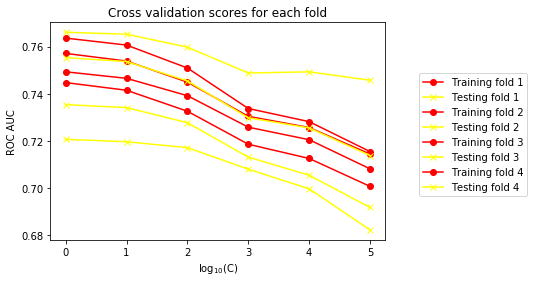

In [48]:
# Plot the average training and testing ROC AUC across folds, for each C value.
for this_fold in range(n_folds):
    plt.plot(range(len(C_vals)), cv_train_roc_auc_poly[this_fold], '-o',
             color='red', label='Training fold {}'.format(this_fold+1))
    plt.plot(range(len(C_vals)), cv_test_roc_auc_poly[this_fold], '-x',
             color='yellow', label='Testing fold {}'.format(this_fold+1))
plt.ylabel('ROC AUC')
plt.xlabel('log$_{10}$(C)')
plt.legend(loc = [1.1, 0.2])
plt.title('Cross validation scores for each fold')

**Take a look at the above graph. Does the average cross-validation testing performance improve with the interaction features? Is regularization useful?**